# Brute Force, Greedy and Ant Colony Optimization

In [140]:
import sys
sys.path.insert(0, '..')

import numpy as np
import time
import itertools
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
%matplotlib inline
import graph_class as gc
import pandas as pd

## 1. Brute Force

In [141]:
import sys
sys.path.insert(0, '../../TSProject/')

# from algorithms import permute as pm
import numpy as np
from time import time
import itertools
import math as mt

# Implementation of the brute force algorithm for TSP
# Input:
#     adj_mat: adjacency matrix
#     symmetric: wheter or not the symmetric property can be used
#     preload: preload permutations (decreases runtime, recommended for graphs <11 nodes only!)
#     *args: maximum number of iterations to generate
# Output:
#     cMin: minimum cost found
#     pMin: associated minimum path
#     time: time needed to execute the algorithm

def bruteForce(graph, symmetric=True, preload=False, *args):
    adj_mat = graph.weighted_adjacency_matrix
    
    # create the permutations for the algorithm
    nNodes = len(adj_mat) -1
    
    # this part is not timed since it does not depend on the input adjacency matrix
    if preload:
        if len(args)>0:
            permList = pm.permute(nNodes,symmetric,args[0])
        else:
            permList = pm.permute(nNodes,symmetric)
        perms = np.array(permList[0])+1
        lastChanges = np.array(permList[1])+1
        
    t1 = time()
    
    cMin = np.inf
    # used for storing previous costs to not compute them again
    cLast = np.zeros([nNodes,1])
    pMin = []
    
    if len(args)>0:
        max_iter = np.min([args[0],mt.factorial(nNodes)])
    else:
        max_iter = mt.factorial(nNodes)
    
    if preload:
        for perm_idx, p in enumerate(perms):
            # reuse previous calculations when possible to speed up the process
            if lastChanges[perm_idx] > 1:
                cCurr = cLast[lastChanges[perm_idx]-2]
            for idx in range(lastChanges[perm_idx]-1,len(p)):
                # If no usable calculations, start from scratch
                if idx == 0:
                    cCurr = adj_mat[0,p[0]]
                    cLast[0] = cCurr
                # For each further one, go through permutations one by one
                else:
                    cCurr = cCurr+adj_mat[p[idx-1],p[idx]]
                    cLast[idx] = cCurr
            # Add the way to the first element at the end
            cCurr = cCurr + adj_mat[p[-1],0]
            if cCurr < cMin:
                pMin = np.append([0],np.append(p,[0]))
                cMin = cCurr
            ttemp = time()
            if (ttemp-t1) > 600:
                break
    else:
        perms = iter((itertools.permutations(range(nNodes))))
        for perm_idx in range(max_iter):            
            p = np.array(next(perms))+1
            if perm_idx == 0:
                lastChanges = 1
                lastRedundant = False
            else:
                if lastRedundant:
                    lastChanges = np.min([lastChanges,[i for i,x in enumerate(plast!=p) if x][0]+1])
                else:
                    lastChanges = [i for i,x in enumerate(plast==p) if x][0]+1
            if p[0]>p[-1]:
                if lastChanges > 1:
                    cCurr = cLast[lastChanges-2]
                for idx in range(lastChanges-1,len(p)):
                    # If no usable calculations, start from scratch
                    if idx == 0:
                        cCurr = adj_mat[0,p[0]]
                        cLast[0] = cCurr
                    # For each further one, go through permutations one by one
                    else:
                        cCurr = cCurr+adj_mat[p[idx-1],p[idx]]
                        cLast[idx] = cCurr
                # Add the way to the first element at the end
                cCurr = cCurr + adj_mat[p[-1],0]
                if cCurr < cMin:
                    pMin = np.append([0],np.append(p,[0]))
                    cMin = cCurr
            else:
                lastRedundant = True            
            plast = p
            ttemp = time()
            if (ttemp-t1) > 600:
                break
                
    # If more than one minimal solution was found in between
    if isinstance(cMin, np.ndarray):
        cMin = cMin[0]
    t2 = time()
    return cMin, pMin, (t2-t1)

# Calculates a set of permutation and associated last changes for TSP
# Input:
#     nNodes: number of nodes in the graph
#     symmetric: whether or not the adjacency matrix is symmetric
#     *args: maximum number of iterations to generate
# Output:
#     l1: list of generated permutations
#     l2: list of indices with the last change

def permute(nNodes, symmetric = False, *args):
    
    if len(args)>0:
        max_iter = min(mt.factorial(nNodes),args[0])
    else:
        max_iter = mt.factorial(nNodes)

    l1 = []
    l2 = []
    lastRedundant = False
    for idx in range(max_iter):
        perm, lastChange = fastPermute(idx, nNodes, symmetric)
        #check if list is empty, i.e. redundant path
        if not perm:
            if not lastRedundant:
                # save the path which was the same for the last (redundant) path
                lastPos = lastChange
                lastRedundant = True
            else:
                # update the path which was the same for each new (redundant) path
                lastPos = np.min([lastPos,lastChange])
        else:
            l1.append(perm)
            # If last permutation(s) were skipped, calculate from last common path
            if lastRedundant:
                l2.append(np.min([lastPos,lastChange]))
                lastRedundant = False
            else:
                l2.append(lastChange)    
    return l1, l2

# Just a junction of calculateFactoradic and getPermutation to cut time in half
def fastPermute(num, nNodes, symmetric):
    nodeList = list(range(nNodes))
    perm = []
    lastChange = 0
    # Get each digit of factoradic which is in base mt.factorial(fact)
    for idx, fact in enumerate(np.arange(nNodes)[::-1]):
        # get base
        hFac = mt.factorial(fact)
        # how often does it fit in base -> nFac
        nFac = int(num/hFac)
        perm.append(nodeList[nFac])
        # update permutation by deleting the nFac-th element from list
        del nodeList[nFac]
        if num > 0 and np.mod(num,hFac) == 0:
            lastChange = idx
        num = np.mod(num,hFac)
    # delete all redundant paths
    if symmetric == True:
        if perm[0] > perm[-1]:
            perm = []
    return perm, lastChange

## 2. Greedy

In [142]:
import sys
sys.path.insert(0, '../../TSProject/')

import numpy as np
import random as rd
from time import time 

# Implementation of the greedy algorithm for TSP
# Input:
#     adj_mat: adjacency matrix
# Output:
#     cost: cost found
#     list_of_traversed_nodes: associated path
#     time: time needed to execute the algorithm

def greedy(graph):
    adj_mat = graph.weighted_adjacency_matrix
    t1 = time()
    nNodes = len(adj_mat)
    firstMove = np.unravel_index(np.argmin(adj_mat),adj_mat.shape)
    listOfTraversedNodes = [firstMove[0],firstMove[1]]
    cost = adj_mat[firstMove[0],firstMove[1]]
    while len(listOfTraversedNodes) < len(adj_mat):
        currentCosts = list(adj_mat[listOfTraversedNodes[-1],:])
        for idx2 in listOfTraversedNodes:
            currentCosts[idx2] = np.inf
        listOfTraversedNodes.append(np.argmin(currentCosts))
        cost += adj_mat[listOfTraversedNodes[-2],listOfTraversedNodes[-1]]
    cost += adj_mat[listOfTraversedNodes[-1],listOfTraversedNodes[0]]
    t2 = time()
    return cost, listOfTraversedNodes + [listOfTraversedNodes[0]], (t2-t1)

## 3. Ant Colony Optimization

In [143]:
import sys
sys.path.insert(0, '../../TSProject/')

import numpy as np
import random as rd
from time import time
import multiprocessing

# Implementation of the ant colony algorithm for TSP
# Input:
#     adj_mat: adjacency matrix
#     num_agents: how many ants are supposed to traverse paths at the same time
#     max_iter: how many times num_agents ants are supposed to be send to traverse
#     alpha, beta: parameters which influence the effect size of the pheromone trail and the path length on the probabilistic update
#     rho: multiplier which regulates the decay rate of the pheromone trail
#     verbose: whether you want print updates every 1000 iterations on the probability distribution of the 
# Output:
#     cost: cost found
#     path: associated path
#     prob_mat: probability matrix obtained in the end (rounded on 2 digits)
#     time: time it took for the algorithm to finish

# inspiration: http://staff.washington.edu/paymana/swarm/stutzle99-eaecs.pdf
# parameter optimization: https://pdfs.semanticscholar.org/30cc/a5e0f5f84d3ad4c4224e247cb418304b4721.pdf
def antColonyOptimization(graph, num_agents=20, max_iter = 1000 , alpha=1, beta=5, rho=0.5, symmetric=True, verbose=0):
    adj_mat = graph.weighted_adjacency_matrix
    t1 = time()
    cmin = np.inf
    pmin = []
    pher_mat = np.ones(adj_mat.shape)
#     prob_mat = np.ones(adj_mat.shape)/len(adj_mat-1)
    prob_mat = np.ones(adj_mat.shape)/(len(adj_mat)-1)
    for idx in range(len(adj_mat)):
        prob_mat[idx,idx]=0
    idx = 0
    tdif = 0
    while idx<max_iter and tdif<600:
        if verbose > 0:
            if np.mod(idx,1000)==0:
                print("Iteration no.",idx,"Result",np.min(np.max(prob_mat,axis=1)))
        # Get random starting points
        positions = rd.choices(range(len(adj_mat)),k=num_agents)
        # find a path with each ant, decay pheromones, update pheromones
        pher_mat, cmin, pmin = traverse_random_multi(adj_mat, prob_mat, pher_mat, cmin, pmin,num_agents, positions, rho, symmetric)
        # Update the probabilities given the new pheromone trails
        prob_mat = update_probs(adj_mat, pher_mat, alpha, beta)
        idx += 1
        ttemp = time()
        tdif = (ttemp-t1)
        
    t2 = time()
    return cmin, pmin, (t2-t1)
    
# sends multiple ants to find a path, updates pheromone trail
def traverse_random_multi(adj_mat, prob_mat, pher_mat, cmin, pmin, num_agents, positions, rho, symmetric):
    results = []
    for idx in range(num_agents):
        path, pheromones, cmin, pmin = traverse_random(adj_mat, prob_mat, positions[idx], cmin, pmin)
        results.append([path, pheromones])
    # Decay the pheromone trail from before
    pher_mat = rho*pher_mat
    # Update the pheromone trail with new paths
    for idx in range(len(results)):
        # if route could not be created
        if not results[idx][0]:
            continue
        for idx2 in range(len(adj_mat)):
            pher_mat[results[idx][0][idx2],results[idx][0][idx2+1]]+=results[idx][1]
            if symmetric:
                pher_mat[results[idx][0][idx2+1],results[idx][0][idx2] ]+=results[idx][1]
    return pher_mat, cmin, pmin
    
# send a single ant to find a path
def traverse_random(adj_mat, prob_mat, position, cmin, pmin):
    initial_position = position
    # Memory of the ants -> tabu list
    path = [initial_position]
    pheromones = 0
    p_mat = np.copy(prob_mat)
    for idx in range(len(adj_mat)-1):
        try:
            probs = np.cumsum(p_mat[position,:])
            probs = probs/probs[-1]
            goal_position = [i for i, x in enumerate(probs-rd.random()) if x>0][0]
        except IndexError: 
            return [], [], cmin, pmin
        for p in path:
            p_mat[goal_position,p] = 0.0
        path.append(goal_position)
        # update function depending of length of the edge
        pheromones += adj_mat[position,goal_position]
        position = goal_position
    pheromones += adj_mat[position,initial_position]
    path.append(initial_position)
    if pheromones < cmin:
        cmin = pheromones
        pmin = path
    pheromones = 1./pheromones
    return path, pheromones, cmin, pmin

# update the probability given the distances and the new pheromone trails
def update_probs(adj_mat, pher_mat, alpha, beta):
    prob_mat = np.zeros(adj_mat.shape)
    for idx in range(len(adj_mat)):
#         tau = np.array([np.min([1,1./x]) for x in 1./adj_mat[idx,:]])
        normalization = np.sum(pher_mat[idx,:]**alpha * (1./adj_mat[idx,:])**beta)
        prob_mat[idx,:] =   (pher_mat[idx,:]**alpha * (1./adj_mat[idx,:])**beta) / normalization
    return prob_mat

# Evaluation of Brute force on sample data

In [123]:
# We use sample data to show how brute force works, since anything above would take too much time

X = [[25,50],
     [15,40],
     [33,65],
     [24,19],
     [7,26],
     [0,37],
     [47,5],
     [56,23],
     [39,18],
     [14,31] ]

In [124]:
c1,p1,t1 = bruteForce(gc.fully_connected_graph_from_coordinate_list(X))
print('Optimum cost: %s, \nOptimum cycle: %s, \nTime: %s seconds.\n'% (c1,p1,t1))

Optimum cost: 182.0, 
Optimum cycle: [0 2 7 6 8 3 9 4 5 1 0], 
Time: 9.01524019241333 seconds.



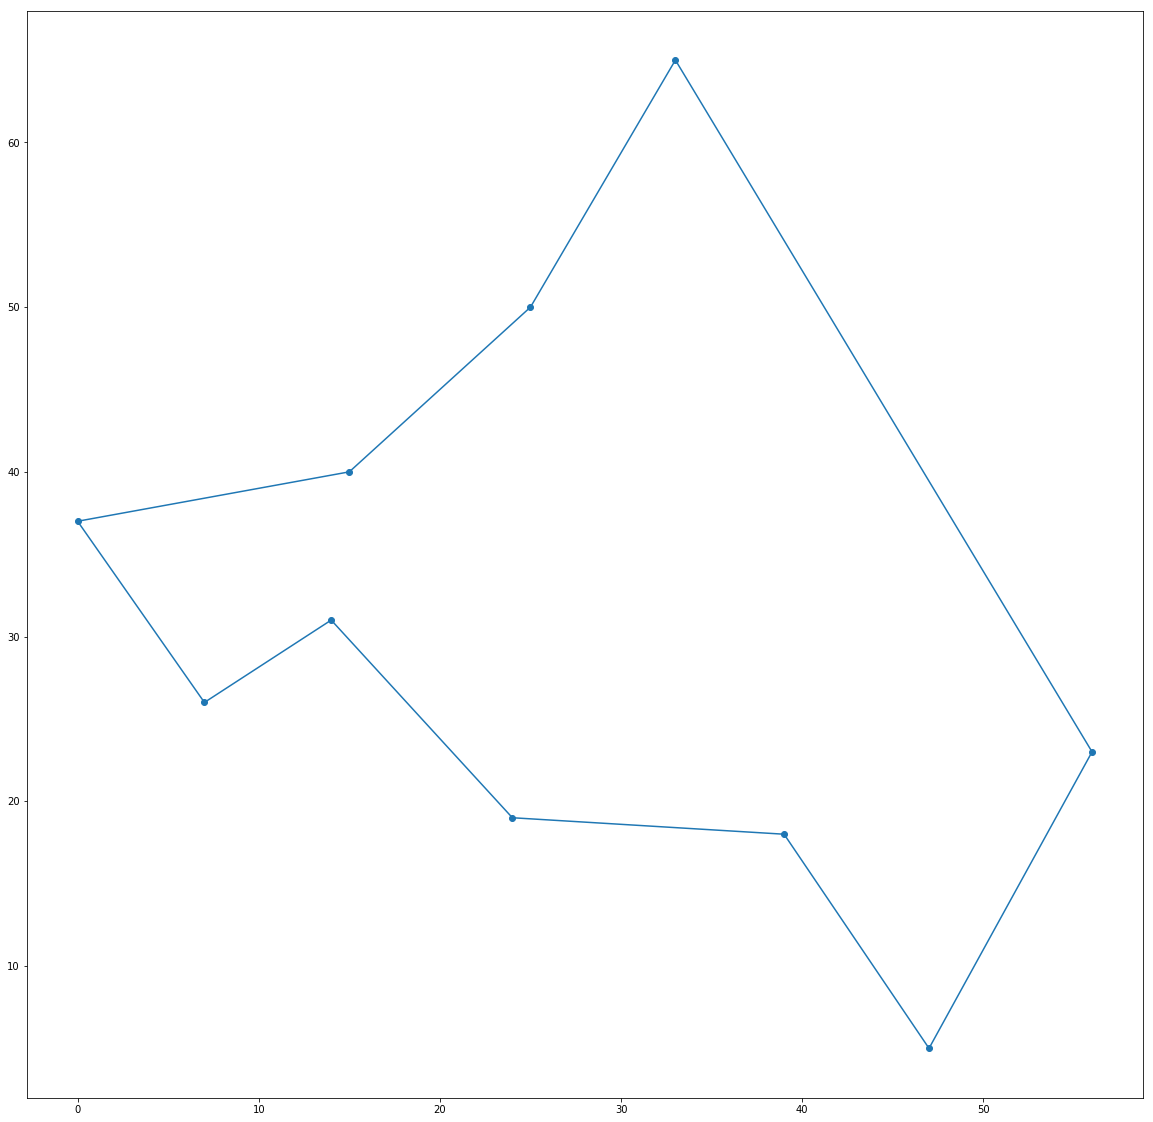

Route: [0 2 7 6 8 3 9 4 5 1 0 0]

Distance:  182.0


In [125]:
data_json = X
total_distance = c1

plt.figure(figsize=(20,20))

data_json = np.array(data_json)

# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(data_json[p1,0],data_json[p1,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)

# Evaluation of Greedy and Ant colony optimization on Heidelberg datasets

In [144]:
# Greedy and Ant Colony are executed on 5 sample datasets from the Heidelberg database
files = [['berlin52',7542],['pr76',108159],['eil101',629],['ch150',6528],['a280',2579]]
datasets = pd.ExcelFile("../data/Symmetrical TSP/all_data_euc2d.xlsx",header=None)

res = {'Dataset':[],
       'Number of cities':[],
       'Distance Greedy':[],
       'Distance ACO':[],
       'Percentage to best Greedy':[],
       'Percentage to best ACO':[]}

# berlin52 dataset

In [145]:
data = np.array(pd.read_excel(datasets,files[0][0],header=None).iloc[:,1:])
graph = gc.fully_connected_graph_from_coordinate_list(data)
c2,p2,t2 = greedy(graph)
c3,p3,t3 = antColonyOptimization(graph)
res['Dataset'].append(files[0][0])
res['Number of cities'].append([52])
res['Distance Greedy'].append(c2)
res['Distance ACO'].append(c3)
res['Percentage to best Greedy'].append((files[0][1]/c2)*100)
res['Percentage to best ACO'].append((files[0][1]/c3)*100)

print('Greedy')
print('Cost: %s, \nCycle: %s, \nTime: %s seconds.\n'% (c2,p2,t2))
print('Ant Colony Optimization')
print('Cost: %s, \nCycle: %s, \nTime: %s seconds.\n'% (c3,p3,t3))

Greedy
Cost: 9161.0, 
Cycle: [34, 35, 33, 38, 39, 37, 36, 47, 23, 4, 14, 5, 3, 24, 45, 43, 15, 49, 19, 22, 30, 17, 21, 0, 48, 31, 44, 18, 40, 7, 9, 8, 42, 32, 50, 11, 27, 26, 25, 46, 12, 13, 51, 10, 28, 29, 20, 16, 2, 41, 6, 1, 34], 
Time: 0.0004994869232177734 seconds.

Ant Colony Optimization
Cost: 7662.0, 
Cycle: [22, 19, 49, 15, 45, 43, 33, 34, 35, 38, 39, 37, 36, 47, 23, 4, 14, 5, 3, 24, 11, 27, 26, 25, 46, 12, 13, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 48, 0, 21, 30, 17, 2, 16, 20, 41, 6, 1, 29, 28, 22], 
Time: 31.306800365447998 seconds.



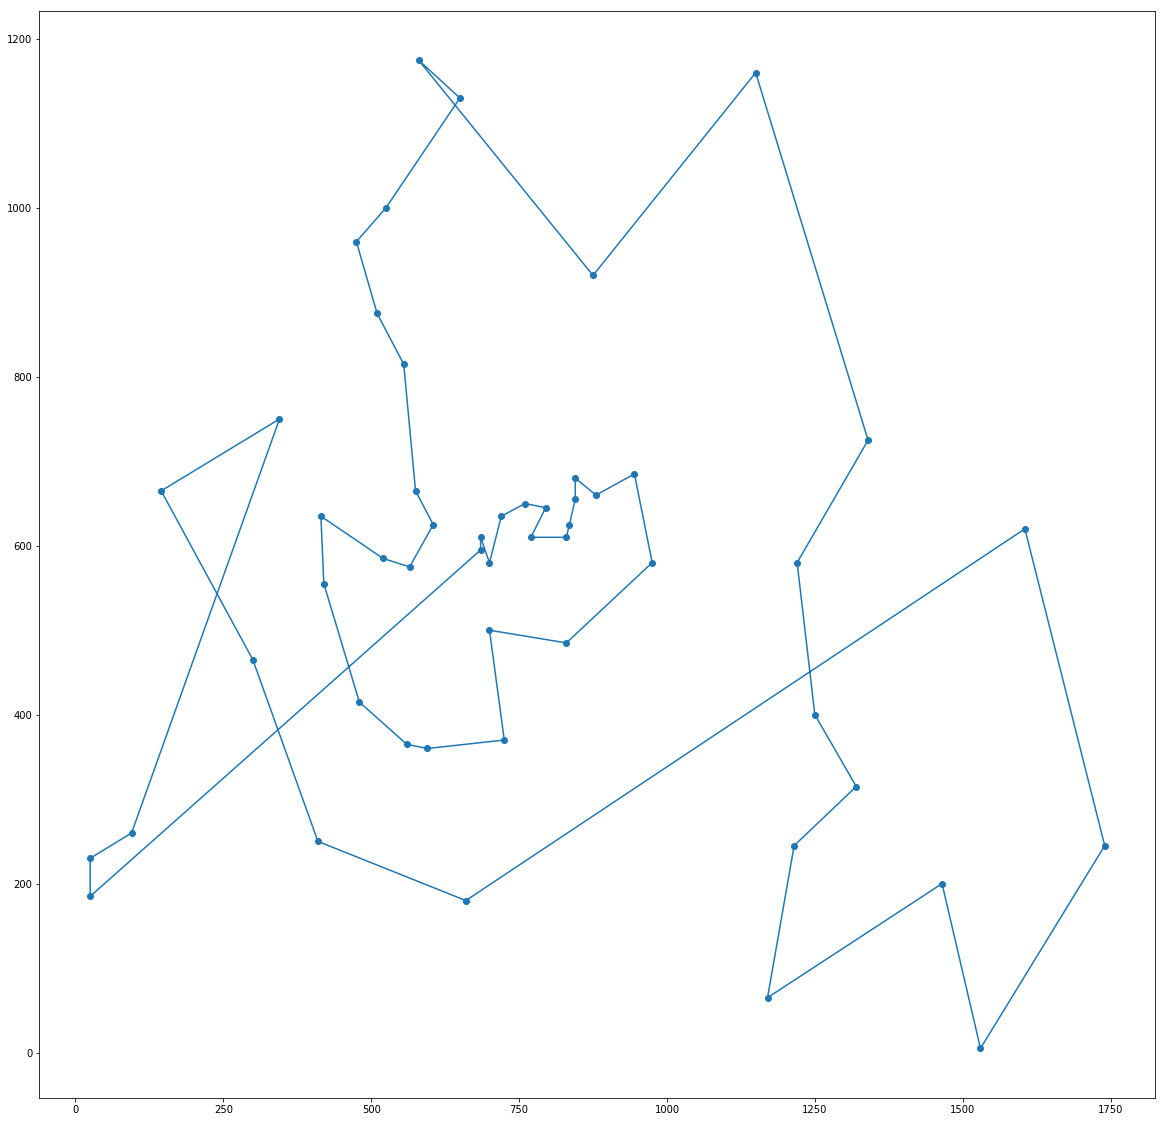

Route: [0 2 7 6 8 3 9 4 5 1 0 0]

Distance:  9161.0


In [146]:
## Route Greedy

data_json = data
total_distance = c2

plt.figure(figsize=(20,20))

# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(data_json[p2,0],data_json[p2,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)

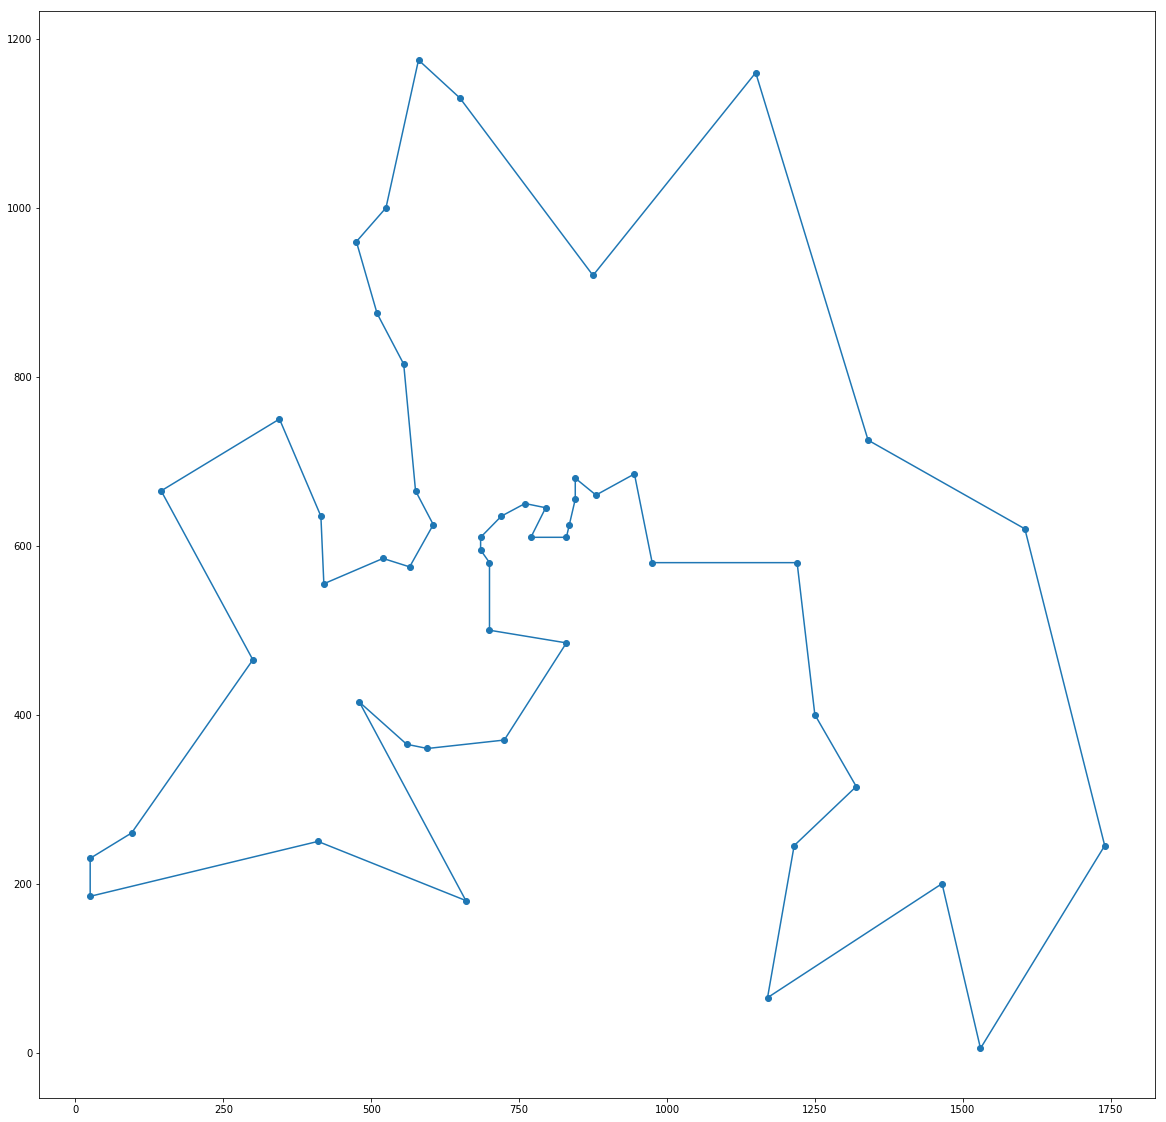

Route: [0 2 7 6 8 3 9 4 5 1 0 0]

Distance:  7662.0


In [147]:
## Route Ant Colony Optimization

data_json = data
total_distance = c3

plt.figure(figsize=(20,20))

# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(data_json[p3,0],data_json[p3,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)

## pr76 dataset

In [148]:
data = np.array(pd.read_excel(datasets,files[1][0],header=None).iloc[:,1:])
graph = gc.fully_connected_graph_from_coordinate_list(data)
c2,p2,t2 = greedy(graph)
c3,p3,t3 = antColonyOptimization(graph)
res['Dataset'].append(files[1][0])
res['Number of cities'].append([76])
res['Distance Greedy'].append(c2)
res['Distance ACO'].append(c3)
res['Percentage to best Greedy'].append((files[1][1]/c2)*100)
res['Percentage to best ACO'].append((files[1][1]/c3)*100)
print('Greedy')
print('Cost: %s, \nCycle: %s, \nTime: %s seconds.\n'% (c2,p2,t2))
print('Ant Colony Optimization')
print('Cost: %s, \nCycle: %s, \nTime: %s seconds.\n'% (c3,p3,t3))

Greedy
Cost: 155010.0, 
Cycle: [71, 72, 70, 63, 62, 56, 57, 58, 59, 40, 39, 33, 34, 35, 36, 17, 16, 10, 11, 12, 13, 14, 15, 9, 8, 5, 6, 7, 2, 3, 4, 19, 18, 30, 29, 28, 27, 42, 41, 53, 52, 51, 50, 65, 64, 55, 54, 48, 49, 66, 67, 68, 46, 47, 43, 44, 45, 23, 24, 20, 21, 22, 0, 1, 74, 75, 25, 26, 32, 31, 37, 38, 60, 61, 69, 73, 71], 
Time: 0.0014967918395996094 seconds.

Ant Colony Optimization
Cost: 117322.0, 
Cycle: [59, 40, 39, 33, 34, 35, 36, 17, 16, 10, 9, 8, 5, 6, 7, 2, 3, 4, 19, 18, 30, 29, 28, 27, 32, 31, 25, 26, 42, 41, 53, 52, 51, 50, 65, 64, 49, 48, 54, 55, 56, 57, 58, 60, 61, 63, 62, 72, 71, 70, 69, 66, 67, 68, 46, 47, 43, 44, 45, 23, 24, 20, 21, 22, 0, 1, 74, 75, 73, 13, 12, 11, 14, 15, 37, 38, 59], 
Time: 61.16429305076599 seconds.



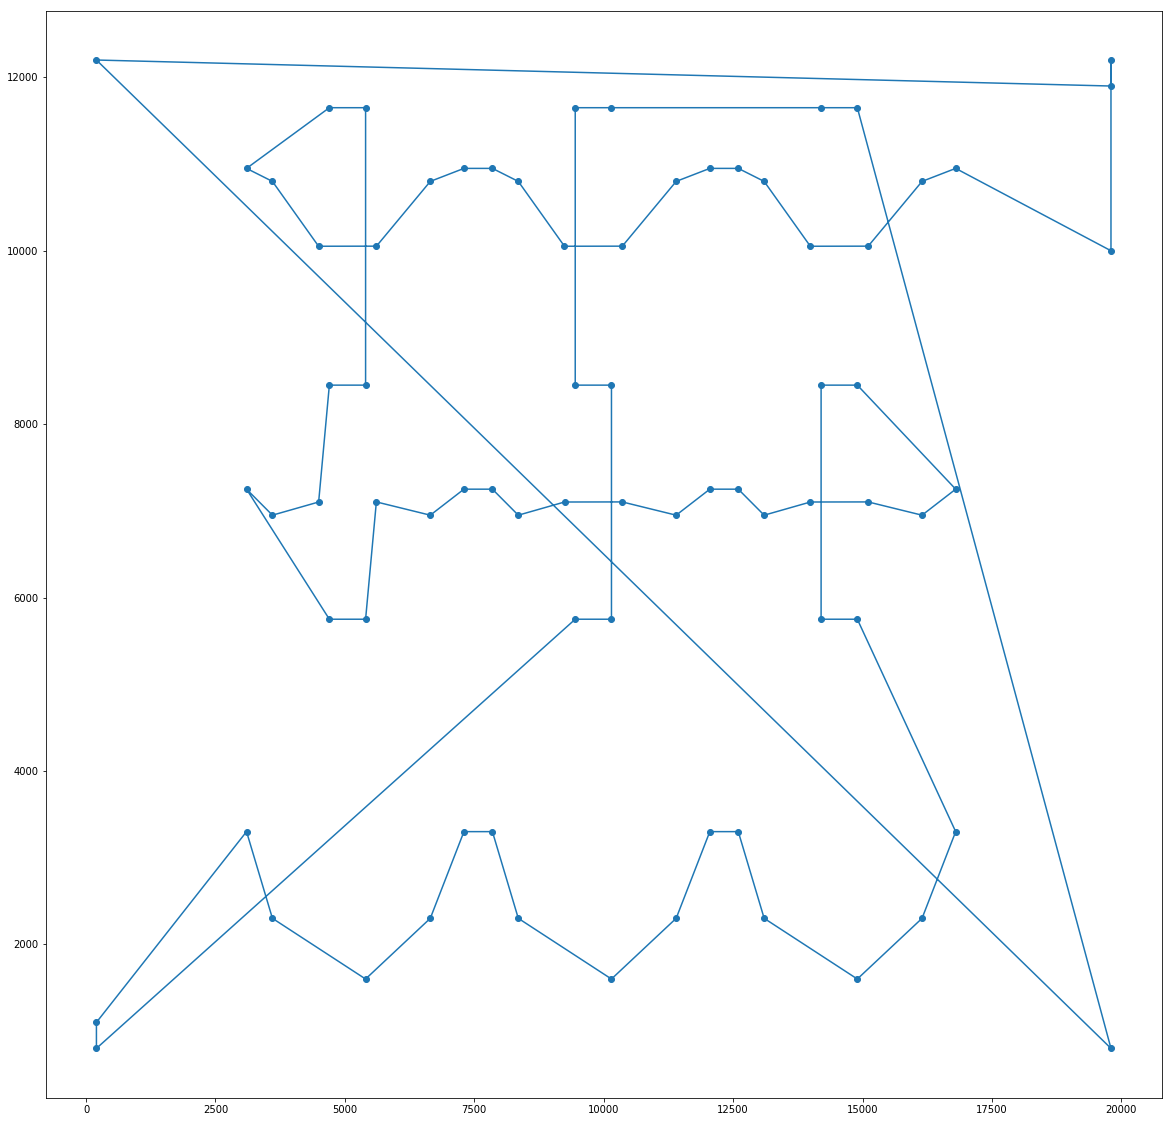

Route: [0 2 7 6 8 3 9 4 5 1 0 0]

Distance:  155010.0


In [149]:
## Route Greedy

data_json = data
total_distance = c2

plt.figure(figsize=(20,20))

# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(data_json[p2,0],data_json[p2,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)

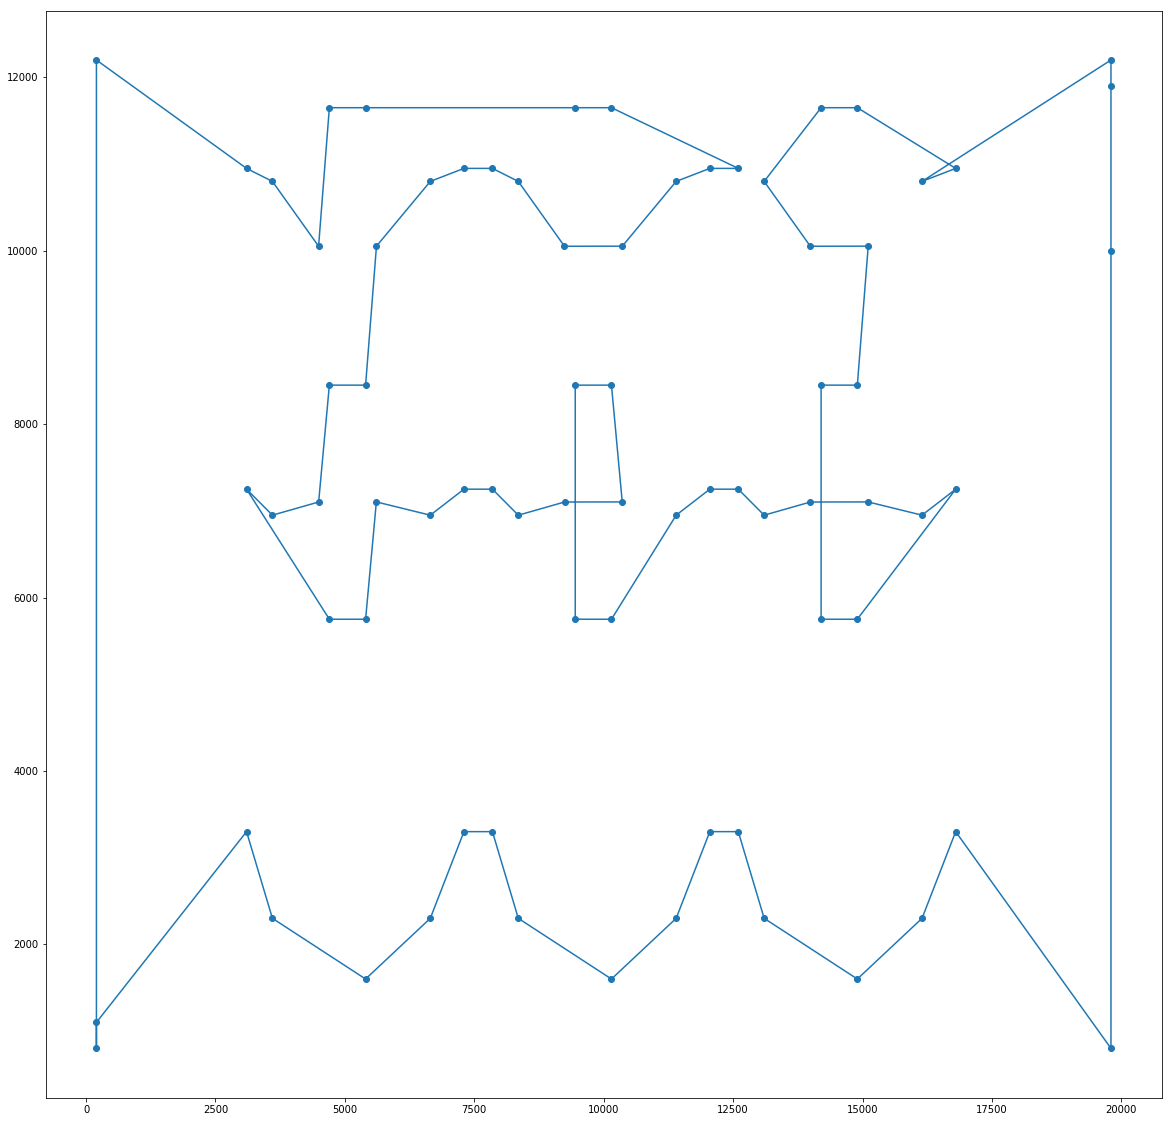

Route: [0 2 7 6 8 3 9 4 5 1 0 0]

Distance:  117322.0


In [150]:
## Route Ant Colony Optimization

data_json = data
total_distance = c3

plt.figure(figsize=(20,20))

# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(data_json[p3,0],data_json[p3,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)

## eil101 dataset

In [151]:
data = np.array(pd.read_excel(datasets,files[2][0],header=None).iloc[:,1:])
graph = gc.fully_connected_graph_from_coordinate_list(data)
c2,p2,t2 = greedy(graph)
c3,p3,t3 = antColonyOptimization(graph)
res['Dataset'].append(files[2][0])
res['Number of cities'].append([101])
res['Distance Greedy'].append(c2)
res['Distance ACO'].append(c3)
res['Percentage to best Greedy'].append((files[2][1]/c2)*100)
res['Percentage to best ACO'].append((files[2][1]/c3)*100)
print('Greedy')
print('Cost: %s, \nCycle: %s, \nTime: %s seconds.\n'% (c2,p2,t2))
print('Ant Colony Optimization')
print('Cost: %s, \nCycle: %s, \nTime: %s seconds.\n'% (c3,p3,t3))

Greedy
Cost: 851.0, 
Cycle: [36, 97, 84, 90, 99, 91, 58, 98, 95, 5, 93, 94, 96, 86, 1, 56, 14, 42, 41, 13, 43, 15, 60, 92, 4, 59, 82, 7, 44, 16, 83, 17, 51, 88, 100, 52, 57, 39, 20, 72, 71, 73, 21, 40, 74, 55, 22, 38, 3, 53, 54, 24, 23, 28, 2, 76, 75, 49, 0, 68, 26, 27, 25, 11, 79, 67, 78, 32, 80, 8, 50, 19, 29, 69, 30, 87, 6, 81, 47, 46, 35, 48, 18, 10, 61, 9, 89, 31, 62, 63, 45, 85, 37, 12, 77, 33, 34, 70, 65, 64, 66, 36], 
Time: 0.0029931068420410156 seconds.

Ant Colony Optimization
Cost: 685.0, 
Cycle: [24, 54, 53, 23, 28, 67, 79, 11, 25, 27, 52, 100, 26, 68, 0, 49, 75, 76, 2, 78, 77, 33, 34, 70, 65, 64, 8, 50, 32, 80, 19, 29, 69, 30, 87, 6, 81, 47, 46, 35, 48, 63, 10, 18, 61, 9, 31, 89, 62, 45, 7, 44, 16, 83, 4, 59, 82, 17, 51, 88, 5, 93, 94, 96, 91, 58, 98, 95, 92, 84, 90, 99, 36, 97, 60, 15, 85, 43, 13, 37, 42, 14, 56, 1, 86, 41, 12, 57, 39, 20, 72, 71, 73, 21, 40, 74, 55, 38, 66, 22, 3, 24], 
Time: 149.87337946891785 seconds.



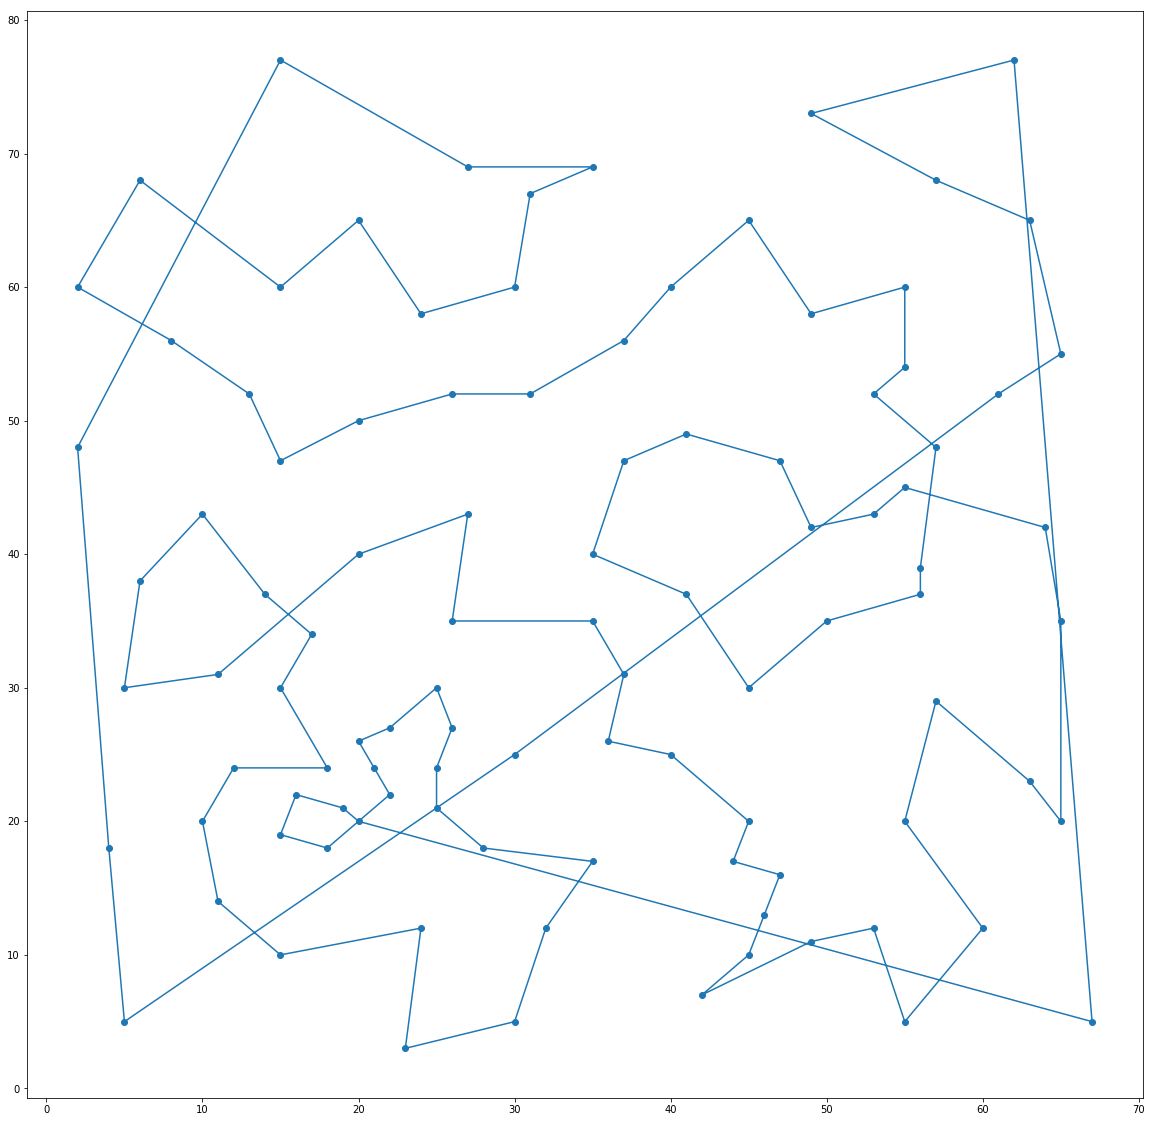

Route: [0 2 7 6 8 3 9 4 5 1 0 0]

Distance:  851.0


In [152]:
## Route Greedy

data_json = data
total_distance = c2

plt.figure(figsize=(20,20))

# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(data_json[p2,0],data_json[p2,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)

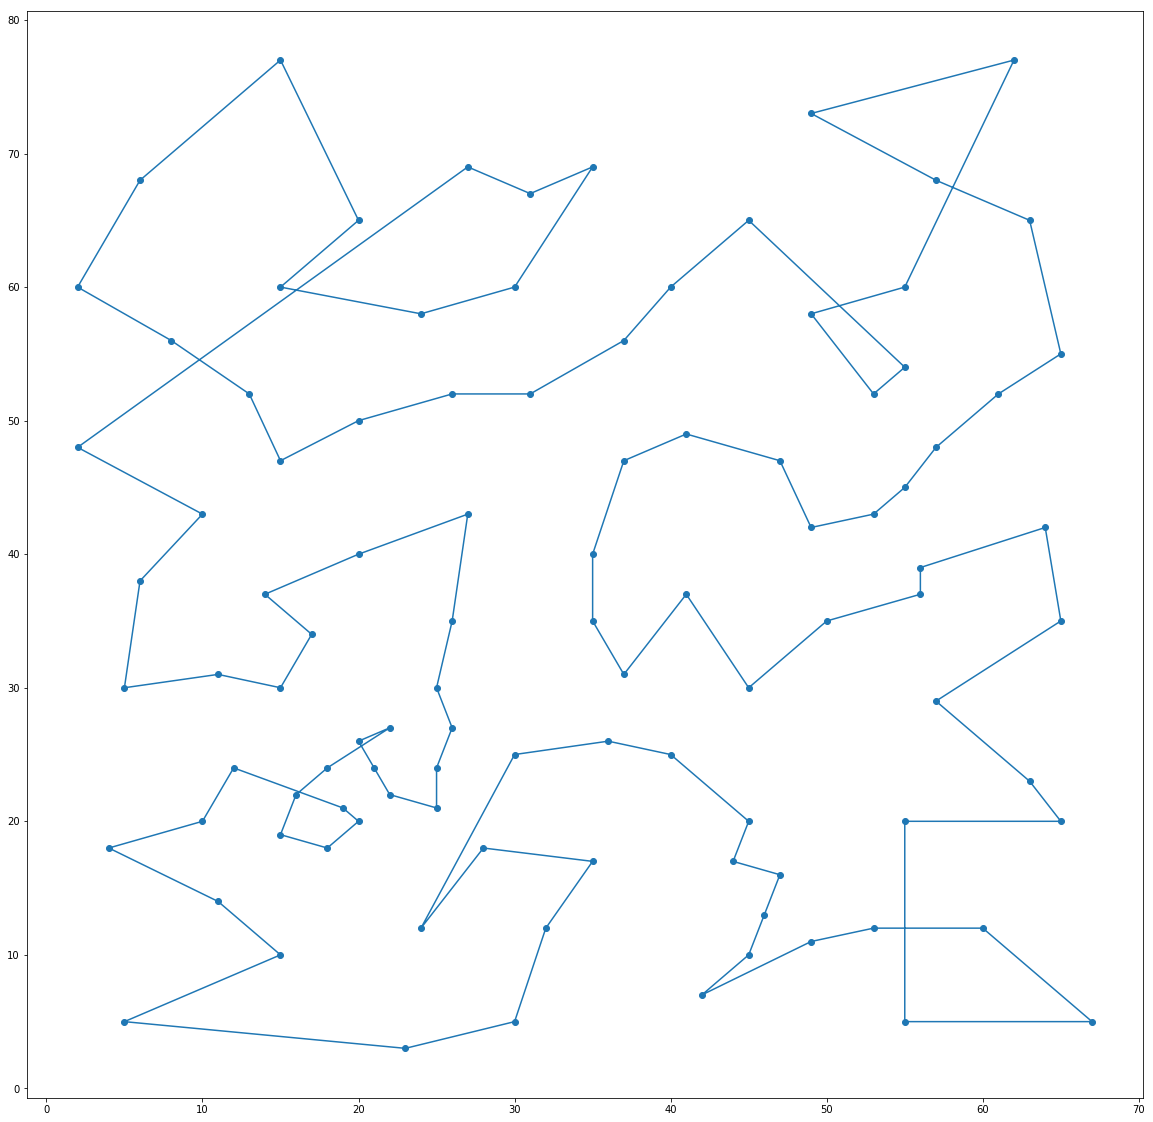

Route: [0 2 7 6 8 3 9 4 5 1 0 0]

Distance:  685.0


In [153]:
## Route Ant Colony Optimization

data_json = data
total_distance = c3

plt.figure(figsize=(20,20))

# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(data_json[p3,0],data_json[p3,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)

## ch150 dataset

In [154]:
data = np.array(pd.read_excel(datasets,files[3][0],header=None).iloc[:,1:])
graph = gc.fully_connected_graph_from_coordinate_list(data)
c2,p2,t2 = greedy(graph)
c3,p3,t3 = antColonyOptimization(graph)
res['Dataset'].append(files[3][0])
res['Number of cities'].append([150])
res['Distance Greedy'].append(c2)
res['Distance ACO'].append(c3)
res['Percentage to best Greedy'].append((files[3][1]/c2)*100)
res['Percentage to best ACO'].append((files[3][1]/c3)*100)
print('Greedy')
print('Cost: %s, \nCycle: %s, \nTime: %s seconds.\n'% (c2,p2,t2))
print('Ant Colony Optimization')
print('Cost: %s, \nCycle: %s, \nTime: %s seconds.\n'% (c3,p3,t3))

Greedy
Cost: 7700.0, 
Cycle: [48, 146, 143, 128, 26, 30, 144, 71, 13, 79, 121, 76, 132, 15, 58, 78, 120, 87, 93, 9, 112, 2, 61, 148, 124, 21, 103, 3, 44, 70, 43, 114, 149, 20, 77, 14, 110, 104, 32, 125, 92, 34, 95, 88, 7, 83, 6, 29, 62, 47, 72, 75, 86, 0, 97, 102, 33, 106, 94, 81, 4, 99, 142, 96, 123, 145, 25, 55, 82, 140, 57, 54, 49, 134, 69, 107, 85, 28, 80, 109, 46, 119, 41, 8, 27, 5, 36, 1, 18, 98, 113, 101, 136, 131, 64, 84, 141, 17, 74, 89, 45, 137, 133, 53, 91, 51, 130, 31, 22, 37, 66, 42, 108, 50, 19, 24, 138, 39, 52, 23, 117, 126, 68, 35, 60, 10, 147, 129, 59, 65, 16, 139, 116, 56, 38, 40, 100, 115, 11, 111, 135, 63, 105, 12, 73, 122, 90, 118, 67, 127, 48], 
Time: 0.0064868927001953125 seconds.

Ant Colony Optimization
Cost: 6725.0, 
Cycle: [56, 38, 100, 115, 11, 23, 117, 52, 39, 138, 119, 41, 8, 27, 5, 36, 1, 18, 98, 113, 101, 136, 131, 64, 84, 141, 17, 74, 25, 145, 55, 82, 89, 45, 137, 133, 53, 91, 32, 125, 92, 34, 95, 88, 7, 83, 6, 29, 62, 47, 72, 75, 86, 0, 97, 102, 33, 81

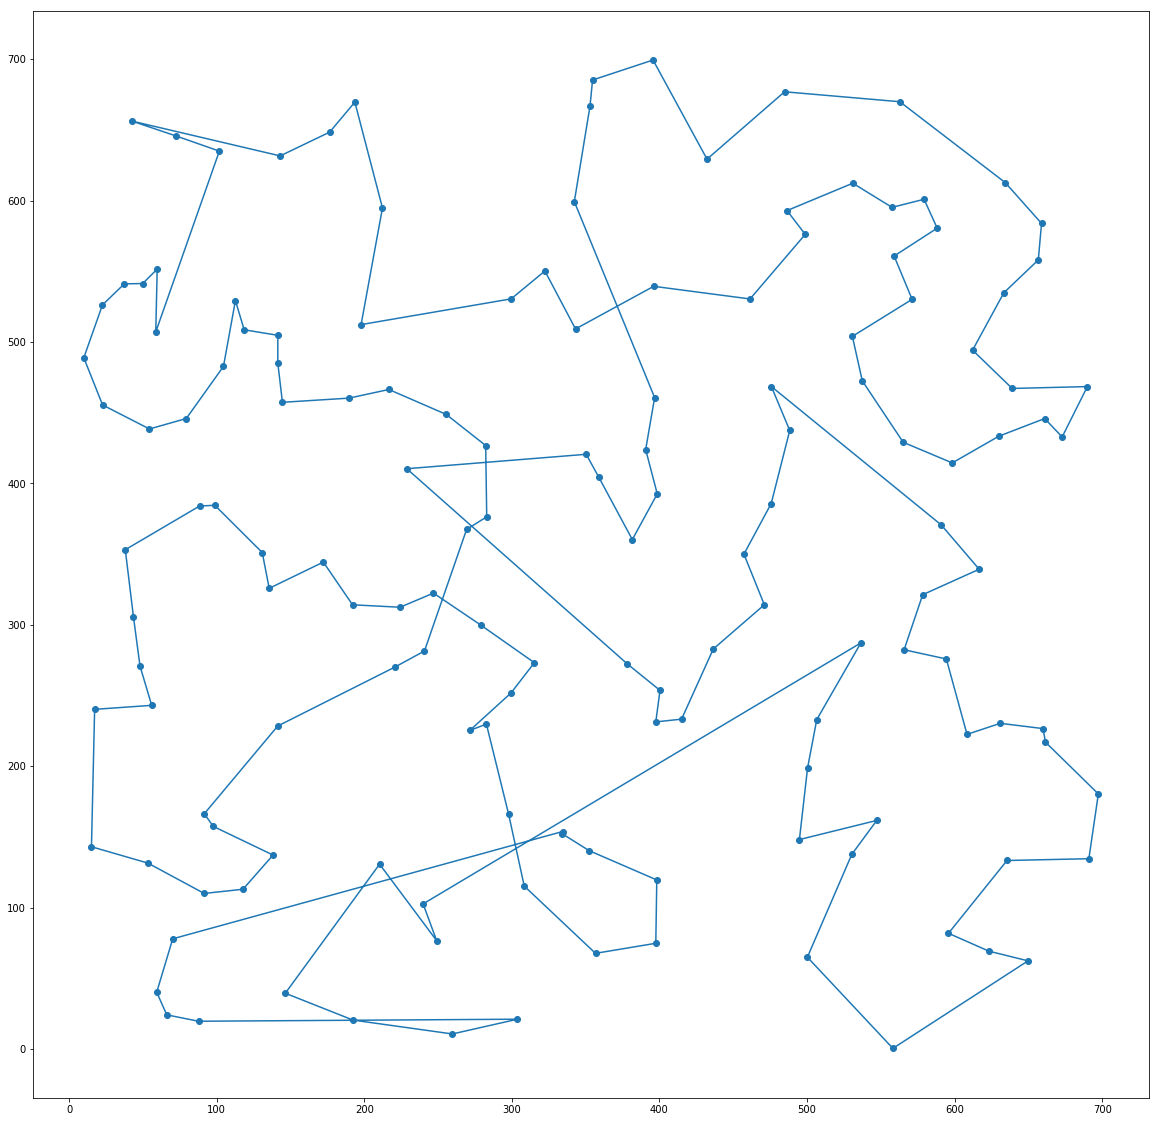

Route: [0 2 7 6 8 3 9 4 5 1 0 0]

Distance:  7700.0


In [155]:
## Route Greedy

data_json = data
total_distance = c2

plt.figure(figsize=(20,20))

# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(data_json[p2,0],data_json[p2,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)

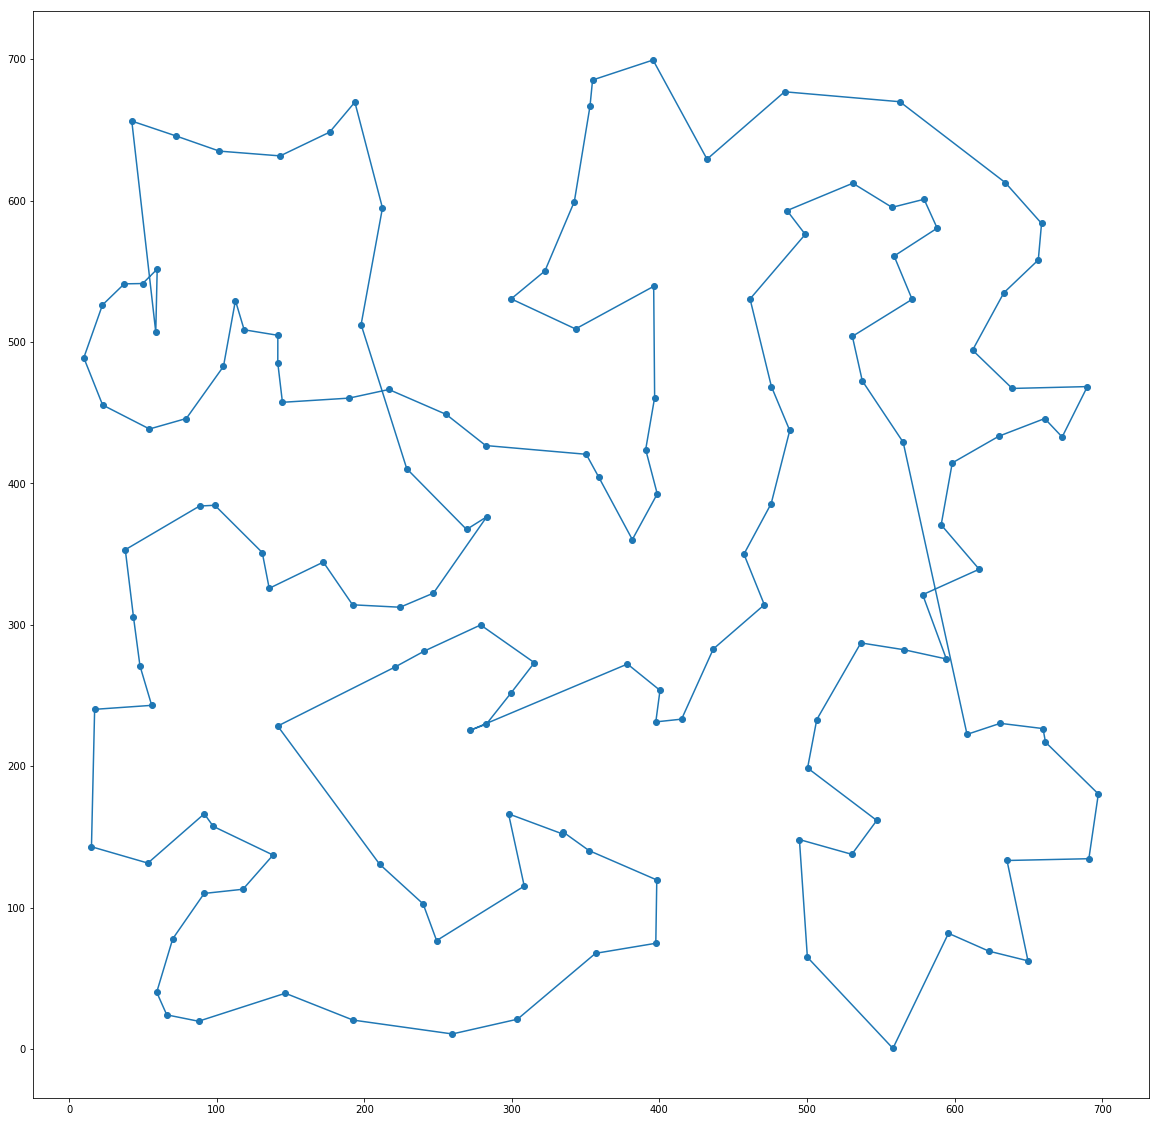

Route: [0 2 7 6 8 3 9 4 5 1 0 0]

Distance:  6725.0


In [156]:
## Route Ant Colony Optimization

data_json = data
total_distance = c3

plt.figure(figsize=(20,20))

# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(data_json[p3,0],data_json[p3,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)

## a280 dataset

In [157]:
data = np.array(pd.read_excel(datasets,files[4][0],header=None).iloc[:,1:])
graph = gc.fully_connected_graph_from_coordinate_list(data)
c2,p2,t2 = greedy(graph)
c3,p3,t3 = antColonyOptimization(graph)
res['Dataset'].append(files[4][0])
res['Number of cities'].append([280])
res['Distance Greedy'].append(c2)
res['Distance ACO'].append(c3)
res['Percentage to best Greedy'].append((files[4][1]/c2)*100)
res['Percentage to best ACO'].append((files[4][1]/c3)*100)
print('Greedy')
print('Cost: %s, \nCycle: %s, \nTime: %s seconds.\n'% (c2,p2,t2))
print('Ant Colony Optimization')
print('Cost: %s, \nCycle: %s, \nTime: %s seconds.\n'% (c3,p3,t3))

C:\Users\fwalo\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\fwalo\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\fwalo\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in true_divide
C:\Users\fwalo\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


Greedy
Cost: 3081.0, 
Cycle: [171, 171, 169, 170, 166, 167, 168, 100, 99, 98, 97, 92, 93, 94, 95, 96, 91, 90, 89, 88, 80, 79, 78, 75, 74, 73, 72, 71, 70, 69, 66, 65, 64, 63, 62, 61, 117, 60, 59, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 30, 29, 124, 123, 122, 121, 120, 119, 118, 156, 157, 158, 159, 174, 160, 161, 162, 163, 164, 165, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 253, 252, 207, 206, 209, 208, 251, 254, 255, 248, 247, 246, 243, 240, 239, 238, 237, 230, 231, 232, 233, 234, 235, 236, 245, 244, 242, 241, 1, 279, 2, 278, 277, 3, 276, 275, 274, 273, 272, 271, 270, 15, 16, 17, 18, 19, 20, 127, 126, 125, 28, 27, 26, 25, 21, 24, 22, 23, 13, 12, 11, 10, 9, 7, 6, 8, 5, 4, 0, 249, 250, 229, 228, 227, 226, 225, 224, 223, 222, 221, 218, 217, 214, 213, 210, 211, 212, 215, 216, 219, 220, 202, 201, 199, 200, 145, 146, 147, 148, 149, 177, 150, 151, 1

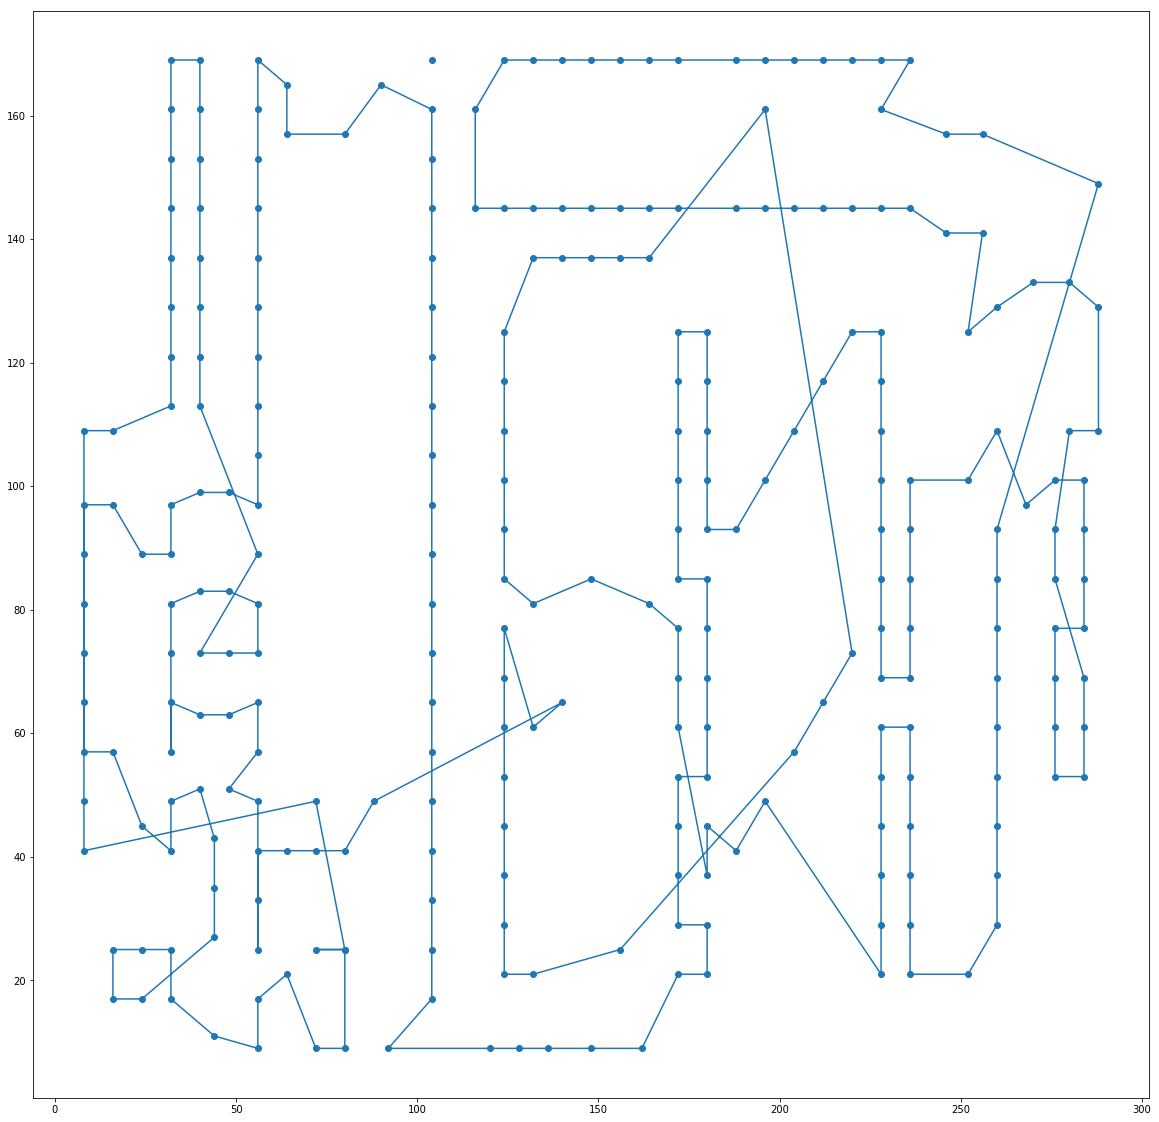

Route: [0 2 7 6 8 3 9 4 5 1 0 0]

Distance:  3081.0


In [158]:
## Route Greedy

data_json = data
total_distance = c2

plt.figure(figsize=(20,20))

# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(data_json[p2,0],data_json[p2,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)

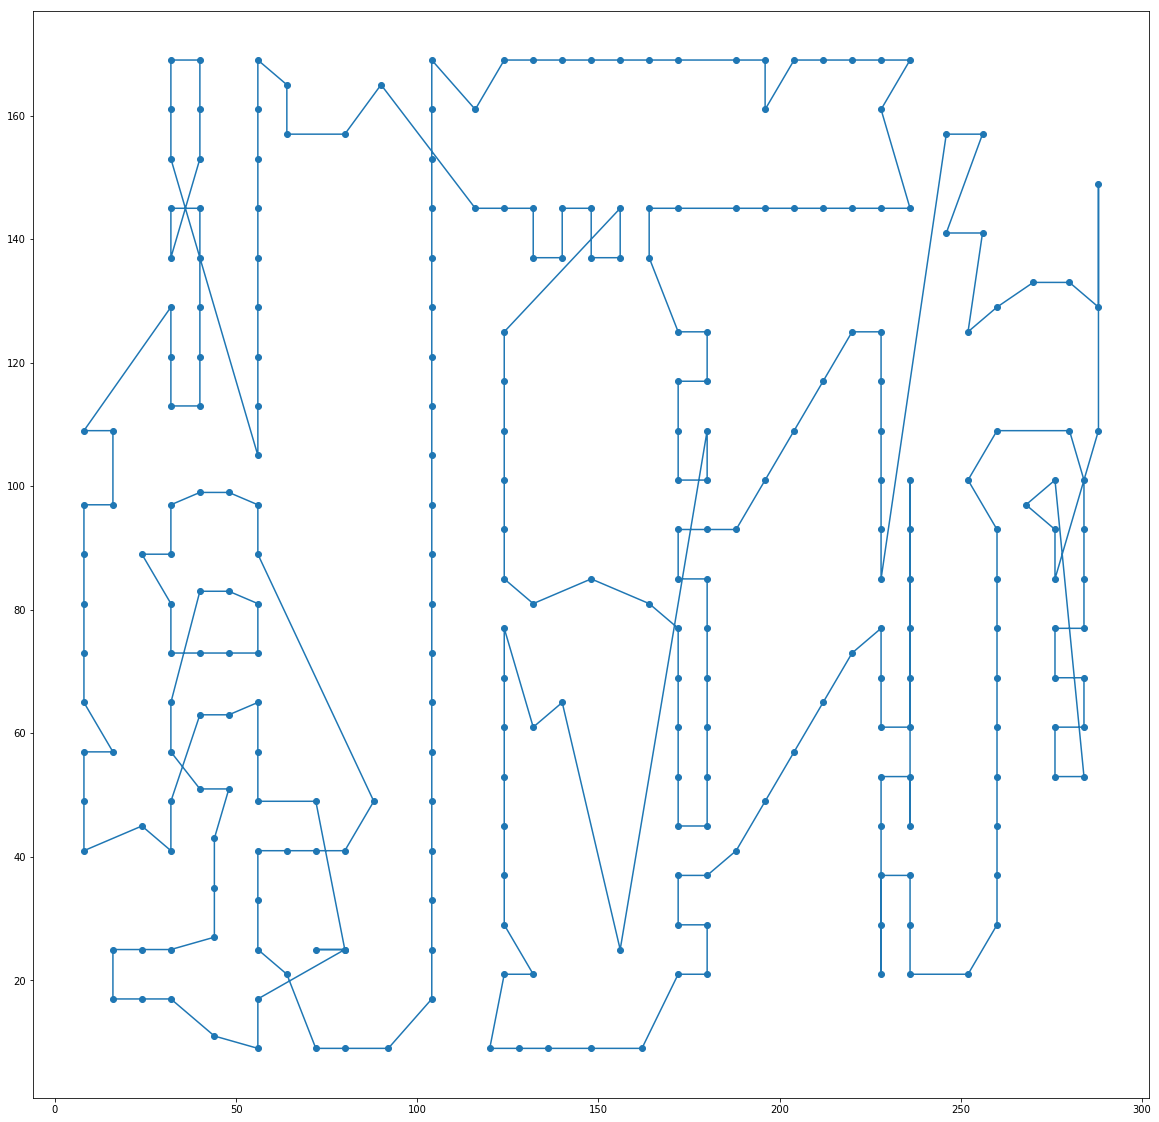

Route: [0 2 7 6 8 3 9 4 5 1 0 0]

Distance:  3086.0


In [159]:
## Route Ant Colony Optimization

## Route Greedy
data_json = data
total_distance = c3

plt.figure(figsize=(20,20))

# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(data_json[p3,0],data_json[p3,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)

In [160]:
res_mat = pd.DataFrame(data=res)
res_mat

,Dataset,Number of cities,Distance Greedy,Distance ACO,Percentage to best Greedy,Percentage to best ACO
0,berlin52,[52],9161.0,7662.0,82.327257,98.433829
1,pr76,[76],155010.0,117322.0,69.775498,92.189871
2,eil101,[101],851.0,685.0,73.913043,91.824818
3,ch150,[150],7700.0,6725.0,84.779221,97.070632
4,a280,[280],3081.0,3086.0,83.706589,83.570966
